# Book 2 - Selecionamento de Features, Validação, Balanceamento

Este notebook serviu como registro prático e teórico no meu aprendizado de Machine Learning.

`Enriqueci este notebook com anotações adicionais e aplicações práticas tornando-o uma referência valiosa para consultas e implementações em futuros projetos reais.`

Espero que este material inspire outros a explorar ainda mais o fascinante mundo do Machine Learning. 

No notebook presente tem todos os topicos dos notebook anteriores, porém sendo acrescentado e aprofundado com anotações dos seguintes tópicos:

**Importância das Features**: Técnicas para identificar as características mais influentes.
- **Select From Model**  
- **SelectKBest**
- **RFE**
- **RFECV**: RFE + Validação Cruzada

**Técnicas de Validação Cruzada**
- **KFolds**: Validação cruzada classica por kfolds.
- **StratifiedKFold**: Validação cruzada estratificada.

**Técnicas de Balanceamento de Dados**  
- **Oversampling - SMOTE**: Criação de dados sintéticos.
- **Undersampling - NearMiss**: Redução de amostras na classe majoritária.
- **Upsampling**: Redução da classe majoritária
- **Downsampling**: Redução a quantidade de amostras da classe majoritária.

Compartilhar conhecimento é uma alegria—viva ao aprendizado contínuo, boa pratica e bons estudo a quem estiver lendo, abraços!

# Funções, bibliotecas e Dataframe ficticios

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('dark_background')
%matplotlib inline

# Manipulação e Tratamento de dados
import openpyxl
import pandas as pd
import numpy as np
from numpy import NaN

#ignorando Warning inuteis
import warnings 
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
# Carregar os dados
url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
df = pd.read_csv(url)

# Identificar colunas a serem removidas # Remover colunas inúteis
columns_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
df = df.drop(columns=columns_to_drop)
df = df.dropna()

df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  712 non-null    int64  
 1   Pclass    712 non-null    int64  
 2   Sex       712 non-null    object 
 3   Age       712 non-null    float64
 4   SibSp     712 non-null    int64  
 5   Parch     712 non-null    int64  
 6   Fare      712 non-null    float64
 7   Embarked  712 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 50.1+ KB


In [4]:
colunas_cat = ['Pclass','Sex','Embarked']
for coluna in colunas_cat:
    df[coluna] = df[coluna].astype('O')

In [5]:
x = df.drop('Survived', axis=1)
y = df['Survived']

In [6]:
# DUMMYRIZAÇÃO
colunas_categoricas = []
colunas_binarias = []
colunas_mais3_categorias = []

for coluna in x.columns:
    if df[coluna].dtype == 'O':
        categorias = x[coluna].unique()
        if len(categorias) == 2:
            print('2 niveis:', coluna, '=>', categorias)
            colunas_categoricas.append(coluna)
            colunas_binarias.append(coluna)
        else:
            print('3 niveis:', coluna, '=>', categorias)
            colunas_categoricas.append(coluna)
            colunas_mais3_categorias.append(coluna)

############################################################################################
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder #transformando colunas com 2 categorias em 0 e 1

coluna = x.columns
one_hot = make_column_transformer((
    OneHotEncoder(drop='if_binary'), #caso a coluna tenha apenas 2 categorias 
    colunas_categoricas), #passando quais são essas colunas
    remainder = 'passthrough', sparse_threshold=0) #oque deve ser feito com as outras

#Aplicando transformação
x = one_hot.fit_transform(x)

#Os novos nomes das colunas #'onehotencoder=transformadas; 'remainder'=não transformadas
novos_nomes_colunas = one_hot.get_feature_names_out(coluna)

x = pd.DataFrame(x, columns = novos_nomes_colunas) #alterando de volta
x_columns = x.columns.tolist() 

############################################################################################
# NORMALIZAÇÃO
from sklearn.preprocessing import MinMaxScaler
normalizacao = MinMaxScaler()
x = normalizacao.fit_transform(x)

#df['Close_padronizada'] = (df[coluna] - df[coluna].mean()) / df[coluna].std()
#df['Close_normalizada'] = (df[coluna] - df[coluna].min()) / (df[coluna].max() - df[coluna].min())

############################################################################################
# DEFININDO A VARIAVEL DEPENDENTE
from sklearn.preprocessing import LabelEncoder
y = LabelEncoder().fit_transform(y)

############################################################################################
x_inteiro = x
y_inteiro = y

# DIVIDINDO BASE EM TREINO E TESTE
from sklearn.model_selection import train_test_split
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, 
                                                    stratify = y, #para manter a proporção da Var Dep nos splits
                                                    random_state = 5) #raiz da aleatoridade
# test_size = 0.25 #porcentagem que ira ser separado para testes

print(x_treino.shape, x_teste.shape)
print(y_treino.shape, y_teste.shape)

3 niveis: Pclass => [3 1 2]
2 niveis: Sex => ['male' 'female']
3 niveis: Embarked => ['S' 'C' 'Q']
(534, 11) (178, 11)
(534,) (178,)


In [7]:
# Função para avaliação de modelos exibindo metricas de avaliação
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, RocCurveDisplay


def avaliar_modelo(y_verdadeiro, y_predito, conjunto_nome):
    """
    Função para avaliar e imprimir o relatório de classificação e a matriz de confusão.
    """
    #if conjunto_nome == "Treino":
     #   pass
    #else:
    print('*' * 70)
    print("Relatório de Classificação para o Conjunto de", conjunto_nome,":\n")
    print(classification_report(y_verdadeiro, y_predito))
    
    print('*' * 55)
    
    print("Matriz de Confusão para o Conjunto de", conjunto_nome,":\n")
    print(confusion_matrix(y_verdadeiro, y_predito))
    print('*' * 70)

    display(RocCurveDisplay.from_predictions(y_verdadeiro, y_predito, name = conjunto_nome))

###############################################################################################
# ou pode-se tbm carregar através de:
'''
import requests
arquivo = 'ML_supervised_learning'
url = "https://raw.githubusercontent.com/GabrielGabes/functions_gsa/main/" + arquivo + ".py"
response = requests.get(url)
code = response.text
exec(code)
'''


'\nimport requests\narquivo = \'ML_supervised_learning\'\nurl = "https://raw.githubusercontent.com/GabrielGabes/functions_gsa/main/" + arquivo + ".py"\nresponse = requests.get(url)\ncode = response.text\nexec(code)\n'

## Modelo Dummy Classifier

**********************************************************************
Relatório de Classificação para o Conjunto de Treino :

              precision    recall  f1-score   support

           0       0.60      1.00      0.75       318
           1       0.00      0.00      0.00       216

    accuracy                           0.60       534
   macro avg       0.30      0.50      0.37       534
weighted avg       0.35      0.60      0.44       534

*******************************************************
Matriz de Confusão para o Conjunto de Treino :

[[318   0]
 [216   0]]
**********************************************************************


**********************************************************************
Relatório de Classificação para o Conjunto de Teste :

              precision    recall  f1-score   support

           0       0.60      1.00      0.75       106
           1       0.00      0.00      0.00        72

    accuracy                           0.60       178
   macro avg       0.30      0.50      0.37       178
weighted avg       0.35      0.60      0.44       178

*******************************************************
Matriz de Confusão para o Conjunto de Teste :

[[106   0]
 [ 72   0]]
**********************************************************************


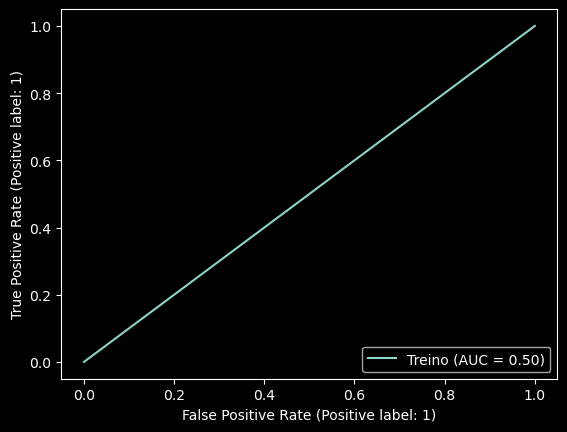

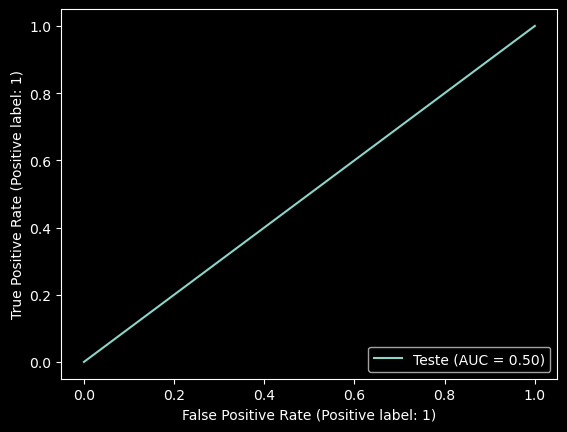

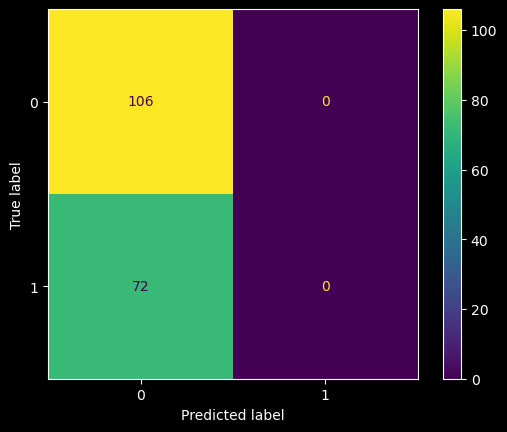

In [8]:
# MODELO BASE
from sklearn.dummy import DummyClassifier
classificador = DummyClassifier()

#######################################################################################
# Treinamento do Modelo
classificador.fit(x_treino, y_treino)

# Avaliação no conjunto de treino # Verificando Over/Under(Fitting)
previsoes_treino = classificador.predict(x_treino)
avaliar_modelo(y_treino, previsoes_treino, "Treino")

# Avaliação no conjunto de teste  # Relatório de classificação
previsoes = classificador.predict(x_teste)
avaliar_modelo(y_teste, previsoes, "Teste")

##############################
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matriz_confusao = confusion_matrix(y_teste, previsoes)
visualizacao = ConfusionMatrixDisplay(confusion_matrix= matriz_confusao)
visualizacao.plot();
#######################################################################################

## Decision Tree

**********************************************************************
Relatório de Classificação para o Conjunto de Treino :

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       318
           1       0.82      0.72      0.76       216

    accuracy                           0.82       534
   macro avg       0.82      0.80      0.81       534
weighted avg       0.82      0.82      0.82       534

*******************************************************
Matriz de Confusão para o Conjunto de Treino :

[[283  35]
 [ 61 155]]
**********************************************************************


**********************************************************************
Relatório de Classificação para o Conjunto de Teste :

              precision    recall  f1-score   support

           0       0.82      0.92      0.87       106
           1       0.86      0.71      0.78        72

    accuracy                           0.84       178
   macro avg       0.84      0.82      0.82       178
weighted avg       0.84      0.84      0.83       178

*******************************************************
Matriz de Confusão para o Conjunto de Teste :

[[98  8]
 [21 51]]
**********************************************************************


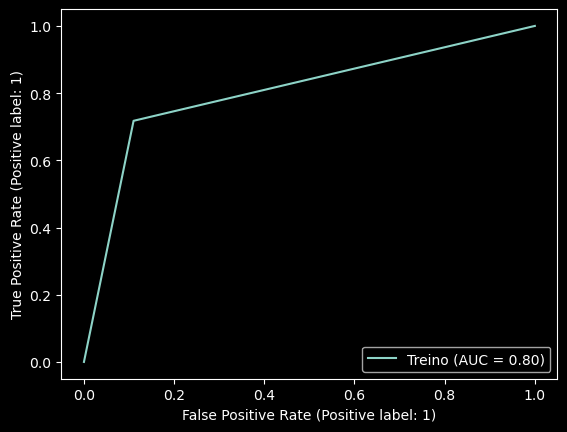

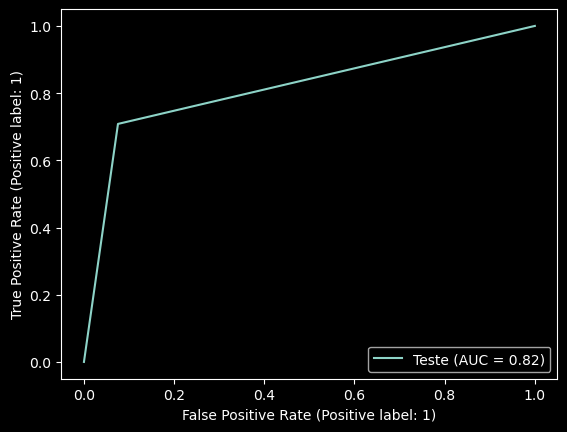

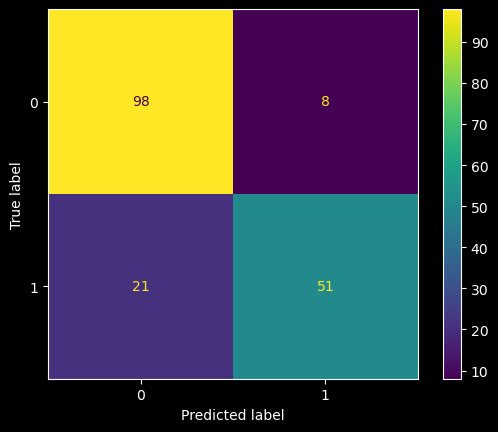

In [9]:
# APLICANDO MODELO
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

classificador = DecisionTreeClassifier(random_state=5, max_depth = 3)
#######################################################################################
# Treinamento do Modelo
classificador.fit(x_treino, y_treino)

# Avaliação no conjunto de treino # Verificando Over/Under(Fitting)
previsoes_treino = classificador.predict(x_treino)
avaliar_modelo(y_treino, previsoes_treino, "Treino")

# Avaliação no conjunto de teste  # Relatório de classificação
previsoes = classificador.predict(x_teste)
avaliar_modelo(y_teste, previsoes, "Teste")

##############################
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matriz_confusao = confusion_matrix(y_teste, previsoes)
visualizacao = ConfusionMatrixDisplay(confusion_matrix= matriz_confusao)
visualizacao.plot();
#######################################################################################

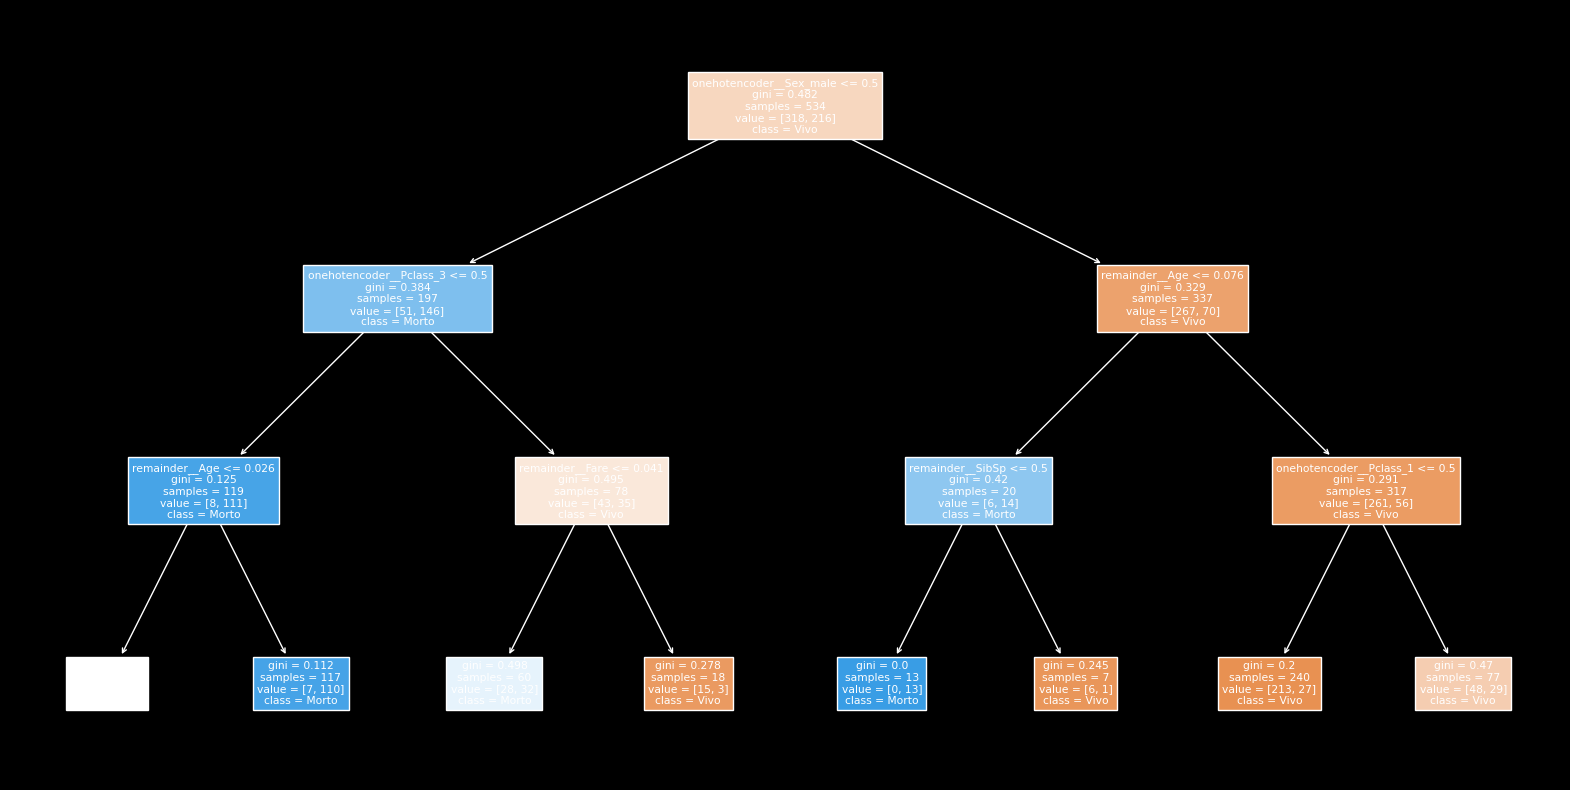

In [10]:
# Visualização da Árvore de Decisão
plt.figure(figsize=(20,10))

plot_tree(classificador, 
          filled = True, #Coloração das caixas do grafico
          class_names = ['Vivo', 'Morto'],
          feature_names=x_columns)

plt.show()

# =======================================

# Validação Cruzada

Exatamente! A validação cruzada é uma ferramenta essencial para avaliar se um modelo tem a capacidade de generalizar bem para dados novos e não vistos, fora do conjunto de treinamento. Ela ajuda a mitigar o risco de overfitting, que é quando um modelo se ajusta perfeitamente aos dados de treinamento, mas falha ao tentar prever resultados em novos conjuntos de dados. 

**Como a Validação Cruzada Ajuda a Entender a Generalização e o Overfitting**

1. **Estimativa de Desempenho Realista:** Ao usar validação cruzada, particularmente o método de validação cruzada estratificada (como `StratifiedKFold`), você obtém uma estimativa mais realista do desempenho do modelo. Cada fold funciona como um teste independente, onde o modelo é treinado em um subconjunto dos dados e testado em outro, ajudando a garantir que os resultados não sejam devidos a peculiaridades de uma divisão específica dos dados.

2. **Variabilidade das Pontuações:** Se a pontuação de um modelo varia significativamente entre os folds, isso pode indicar que o modelo é sensível a variações nos dados de treinamento, um sinal de que o modelo pode estar sobreajustado. Modelos bem generalizados tendem a ter desempenhos mais consistentes entre os diferentes folds.

3. **Comparação com o Desempenho em Dados de Treinamento:** Se as pontuações da validação cruzada forem significativamente mais baixas do que as pontuações do modelo nos dados de treinamento, isso é um forte indicativo de overfitting. Um modelo bem ajustado terá desempenho similar tanto nos dados de treinamento quanto nos dados de validação.

**Conclusão após a Validação Cruzada**

- **Decisão sobre o Modelo:** Com base nos resultados da validação cruzada, você pode decidir se um modelo é adequado ou não para continuar no processo de desenvolvimento. Se um modelo mostra sinais claros de overfitting, ou se não consegue generalizar bem segundo os resultados da validação cruzada, talvez seja necessário reconsiderar suas escolhas de hiperparâmetros, experimentar outro tipo de modelo, ou adotar técnicas para reduzir a complexidade do modelo.
  
- **Ajuste de Hiperparâmetros:** A validação cruzada não só ajuda a verificar a generalização do modelo, mas também é uma ferramenta útil para o ajuste fino dos hiperparâmetros, procurando o equilíbrio ideal entre viés e variância.

• Uma média alta sugere que o modelo está se saindo bem, enquanto uma variação alta nos scores entre os folds pode indicar que o modelo pode estar sofrendo de overfitting ou underfitting, dependendo do contexto.

• Se a pontuação de um modelo varia significativamente entre os folds, isso pode indicar que o modelo é sensível a variações nos dados de treinamento, um sinal de que o modelo pode estar sobreajustado. Modelos bem generalizados tendem a ter desempenhos mais consistentes entre os diferentes folds.

• Se as pontuações da validação cruzada forem significativamente mais baixas do que as pontuações do modelo nos dados de treinamento, isso é um forte indicativo de overfitting. Um modelo bem ajustado terá desempenho similar tanto nos dados de treinamento quanto nos dados de validação

• Decisão sobre o Modelo: Com base nos resultados da validação cruzada, você pode decidir se um modelo é adequado ou não para continuar no processo de desenvolvimento. Se um modelo mostra sinais claros de overfitting, ou se não consegue generalizar bem segundo os resultados da validação cruzada, talvez seja necessário reconsiderar suas escolhas de hiperparâmetros, experimentar outro tipo de modelo, ou adotar técnicas para reduzir a complexidade do modelo.

• Ajuste de Hiperparâmetros: A validação cruzada não só ajuda a verificar a generalização do modelo, mas também é uma ferramenta útil para o ajuste fino dos hiperparâmetros, procurando o equilíbrio ideal entre viés e variância.

Portanto, a validação cruzada é crucial para validar a robustez de um modelo de aprendizado de máquina, permitindo identificar e corrigir problemas antes de finalizar o modelo e utilizá-lo para fazer previsões em situações reais.

In [19]:
# PARA AVALIAR A VALIDAÇÃO CRUZADA
def intervalo_conf(resultados):
    media = resultados.mean()
    desvio_padrao = resultados.std()
    ic_0 = round(media - 2*desvio_padrao, 2)
    ic_1 = round(min(media + 2*desvio_padrao, 1), 2)
    ic = '[' + str(ic_0) + ' - ' + str(ic_1) + ']'
    return ic

def histograma(dados):
    dados = dados
    plt.figure(figsize=(15,5))
    plt.hist(dados, edgecolor='black', density=True) #bins=q_bins, 

    plt.title('hist', fontsize=15)
    plt.grid(True, color='gray')

    # Adicionar linhas verticais para média e mediana
    plt.axvline(x = dados.mean(), color='red', linestyle='--', label='Média')
    plt.axvline(x = dados.median(), color='blue', linestyle='--', label='Mediana')

    # Adicionar legenda personalizada
    texto_count = 'Count = ' + str(round(len(dados), 0))
    texto_media = 'Média = '+ str(round(dados.mean(), 2))
    texto_dp = 'DP = '+ str(round(dados.std(), 2))
    texto_min = 'Min = '+ str(round(dados.min(), 2))
    texto_Q1 = 'Q1 = ' + str(round(dados.quantile(0.25), 2))
    texto_mediana = 'Q2 = '+ str(round(dados.median(), 2))
    texto_Q3 = 'Q3 = ' + str(round(dados.quantile(0.75), 2))
    texto_max = 'Max = '+ str(round(dados.max(), 2))
    ic = 'IC ' + intervalo_conf(dados)
    texto_legenda = '\n'.join([texto_count, 
                               texto_min,
                               texto_media, texto_dp, 
                               texto_Q1, texto_mediana, texto_Q3,
                               texto_max, 
                               ic])

    plt.text(0.99, 0.96, texto_legenda, ha='right', va='top', transform=plt.gca().transAxes,
             bbox=dict(facecolor='black', edgecolor='gray', boxstyle='round'),
             fontsize=12)

    plt.show()

###############################################################################################
# ou pode-se tbm carregar através de:
'''
import requests
arquivo = 'funcoes_estatisticas'
url = "https://raw.githubusercontent.com/GabrielGabes/functions_gsa/main/" + arquivo + ".py"
response = requests.get(url)
code = response.text
exec(code)
'''


'\nimport requests\narquivo = \'funcoes_estatisticas\'\nurl = "https://raw.githubusercontent.com/GabrielGabes/functions_gsa/main/" + arquivo + ".py"\nresponse = requests.get(url)\ncode = response.text\nexec(code)\n'

## KFolds

**Funcionamento**

1. **Divisão do Conjunto de Dados:**
   O conjunto de dados é dividido aleatoriamente em \( k \) subconjuntos (ou "folds") de aproximadamente igual tamanho.

2. **Execução Iterativa:**
   O modelo é treinado e validado \( k \) vezes, com cada uma das \( k \) partes sendo usada exatamente uma vez como conjunto de teste, enquanto as \( k-1 \) partes restantes formam o conjunto de treino.

3. **Treinamento e Validação:**
   - Em cada iteração, o modelo é treinado com \( k-1 \) folds e testado no fold restante.
   - Isso permite que o modelo seja validado de maneira justa, utilizando todo o conjunto de dados para treino e teste ao longo das \( k \) iterações.

4. **Avaliação do Modelo:**
   - Após o treinamento, os resultados de cada fold são usados para estimar a eficácia do modelo, tipicamente através da média das métricas de desempenho (como precisão, recall, F1-score, etc.) obtidas em cada fold.

Ao escolher o valor de \( k \), um equilíbrio deve ser encontrado entre o custo computacional e a precisão da estimativa. Um valor comum é \( k=10 \), mas valores como \( k=5 \) ou \( k=20 \) também são usados dependendo do tamanho e da natureza do conjunto de dados.

,fit_time,score_time,test_score
4,0.000000,0.007684,0.773585
8,0.002598,0.000000,0.849057
0,0.003584,0.000000,0.777778


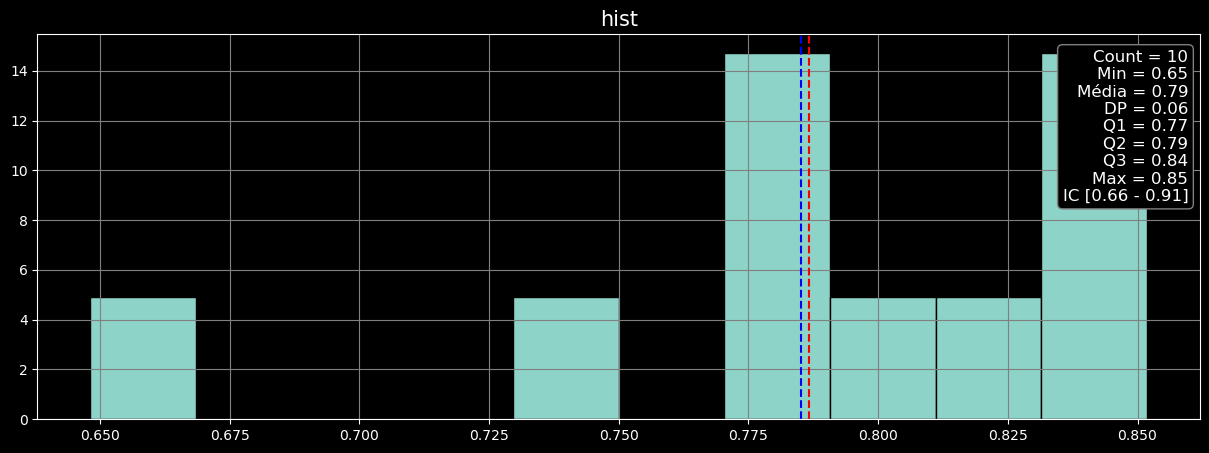

In [20]:
# VALIDAÇÃO CRUZADA
from sklearn.model_selection import cross_validate, KFold

classificador = DecisionTreeClassifier(max_depth = 10, random_state = 5)
kf = KFold(n_splits = 10, shuffle = True, random_state = 5)
cv_resultados = cross_validate(classificador, x_treino, y_treino, cv = kf)

cv_resultados = pd.DataFrame(cv_resultados)
display(cv_resultados.sample(3))

# colunas: 
# fit_time: tempo que levou para ajustar o modelo
# score_time: tempo que levou para calcular pontuação
# test_score: score obtidos pelo modelo em cada fold

# Analise graficas pontuações
histograma(cv_resultados['test_score']) # minha função de plotar histograma

import plotly.express as px
fig = px.violin(cv_resultados, x='test_score', box=True, points="all")
fig.show()

**Quando você executa cross_validate, está fazendo o seguinte:**

- **Usando o modelo 'classificador' como base:** Você passa a instância não treinada 'classificador' para cross_validate.
- **Treinamento e Teste em Folds:** O cross_validate automaticamente treina o modelo nos conjuntos de treinamento de cada fold e o testa nos conjuntos de teste correspondentes.
- **Independente do Modelo Original:** Cada fold usa uma cópia independente do modelo 'classificador'. 

Portanto, o treinamento feito durante a validação cruzada não afeta a instância original 'classificador'.
Média das Pontuações: A função calcula e retorna várias métricas, incluindo as pontuações de teste para cada fold. A média dessas pontuações é frequentemente usada para avaliar o desempenho geral do modelo.

E apartir daqui após avaliar a generalização apartir da distribuição do escore gerados, toma-se a decisão de seguir ou não com o modelo.

**********************************************************************
Relatório de Classificação para o Conjunto de Teste :

              precision    recall  f1-score   support

           0       0.76      0.84      0.80       106
           1       0.72      0.61      0.66        72

    accuracy                           0.75       178
   macro avg       0.74      0.73      0.73       178
weighted avg       0.74      0.75      0.74       178

*******************************************************
Matriz de Confusão para o Conjunto de Teste :

[[89 17]
 [28 44]]
**********************************************************************


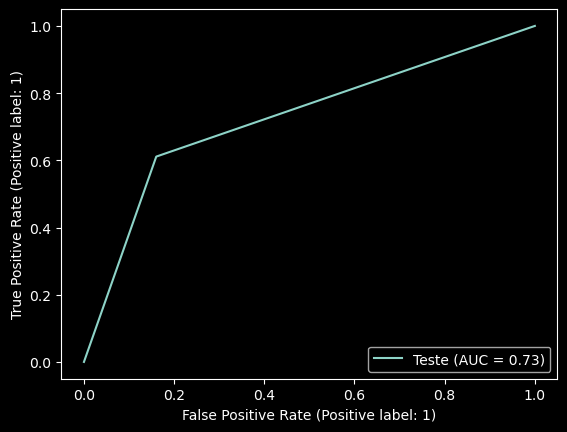

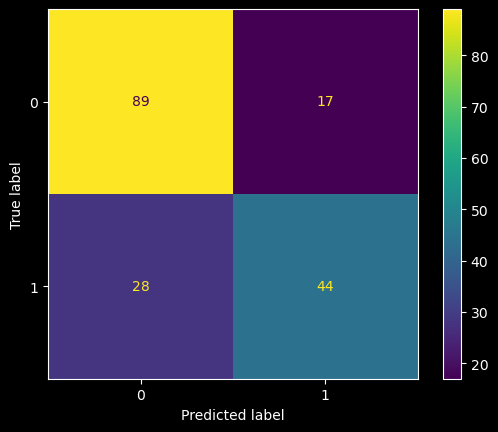

In [21]:
#######################################################################################
# Treinamento do Modelo
classificador.fit(x_treino, y_treino)

# Avaliação no conjunto de teste  # Relatório de classificação
previsoes = classificador.predict(x_teste)
avaliar_modelo(y_teste, previsoes, "Teste")

##############################
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matriz_confusao = confusion_matrix(y_teste, previsoes)
visualizacao = ConfusionMatrixDisplay(confusion_matrix= matriz_confusao)
visualizacao.plot();
#######################################################################################

## StratifiedKFold - Validação Cruzada Estratificada

`StratifiedKFold` é uma variação da validação cruzada \( k \)-folds que busca melhorar a representatividade das amostras em cada fold, especialmente útil em conjuntos de dados desbalanceados. Ao invés de dividir o conjunto de dados de forma completamente aleatória, este método divide os dados de forma que a proporção de cada classe seja preservada em cada fold.

- **Melhor Representatividade:** Reduz o risco de viés no treinamento e teste devido a amostras não representativas de cada classe.
- **Maior Confiança nos Resultados:** Ao garantir que todas as classes estejam adequadamente representadas, a validação cruzada estratificada oferece uma avaliação mais precisa e confiável do desempenho do modelo.

**Funcionamento**

1. **Estratificação dos Dados:**
   Antes da divisão em \( k \) folds, o conjunto de dados é estratificado. Isso significa que a proporção de cada categoria de resposta (como "sim" ou "não" em uma variável binária) é mantida constante em cada fold.

2. **Execução Iterativa:**
   Como na validação cruzada \( k \)-folds, o modelo é treinado \( k \) vezes. Cada iteração usa um fold diferente como conjunto de teste, e os \( k-1 \) folds restantes como conjunto de treino.

3. **Treinamento e Validação:**
   - Em cada iteração, o modelo é treinado nos \( k-1 \) folds estratificados e validado no fold de teste.
   - Isso assegura que cada fold de teste é uma representação fiel da distribuição geral das classes, tornando os resultados do teste mais confiáveis.

4. **Avaliação do Modelo:**
   - A performance do modelo é avaliada em cada fold, utilizando métricas de desempenho adequadas para cada tipo de resposta. A média dessas métricas pode ser calculada para fornecer uma estimativa robusta da capacidade de generalização do modelo.

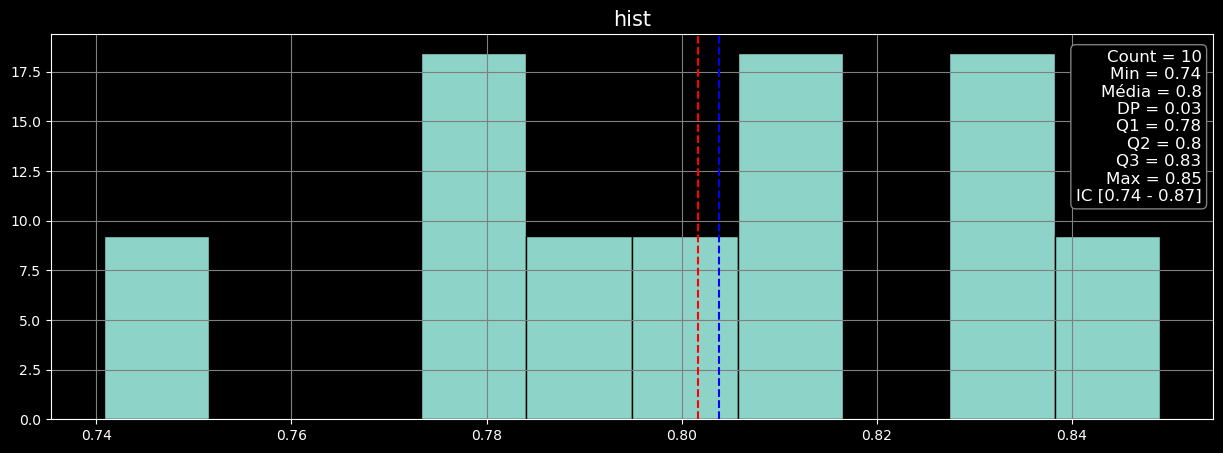

In [22]:
# VALIDAÇÃO CRUZADA ESTRATIFICADA
from sklearn.model_selection import cross_validate, StratifiedKFold

classificador = DecisionTreeClassifier(random_state=5, max_depth = 3)
skf = StratifiedKFold(n_splits = 10, 
                      shuffle = True, # embaralhamento dos dados
                      random_state = 5)
cv_resultados = cross_validate(classificador, x_treino, y_treino, cv = skf)

cv_resultados = pd.DataFrame(cv_resultados)
#display(cv_resultados.sample(3))

# colunas: 
# fit_time: tempo que levou para ajustar o modelo
# score_time: tempo que levou para calcular pontuação
# test_score: score obtidos pelo modelo em cada fold

# Analise graficas pontuações
histograma(cv_resultados['test_score']) # minha função de plotar histograma

import plotly.express as px
fig = px.violin(cv_resultados, x='test_score', box=True, points="all")
fig.show()

**********************************************************************
Relatório de Classificação para o Conjunto de Teste :

              precision    recall  f1-score   support

           0       0.82      0.92      0.87       106
           1       0.86      0.71      0.78        72

    accuracy                           0.84       178
   macro avg       0.84      0.82      0.82       178
weighted avg       0.84      0.84      0.83       178

*******************************************************
Matriz de Confusão para o Conjunto de Teste :

[[98  8]
 [21 51]]
**********************************************************************


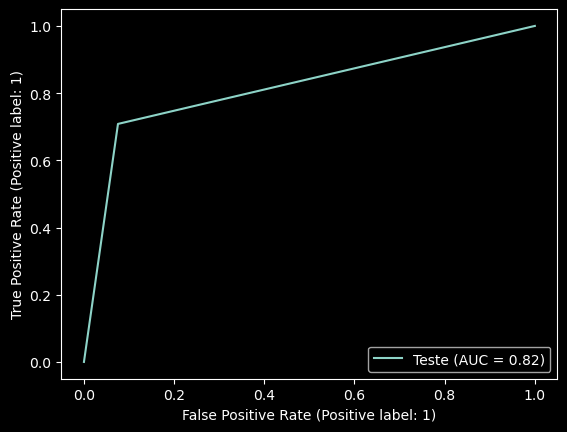

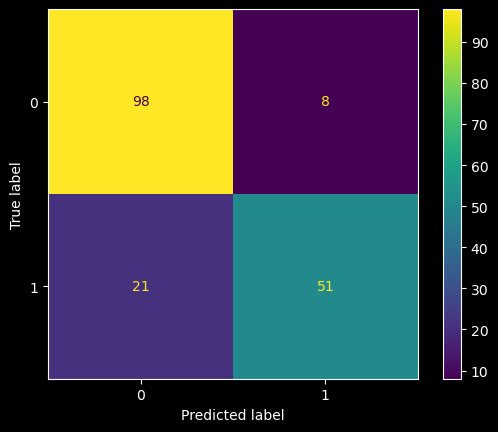

In [23]:
#######################################################################################
# Treinamento do Modelo
classificador.fit(x_treino, y_treino)

# Avaliação no conjunto de teste  # Relatório de classificação
previsoes = classificador.predict(x_teste)
avaliar_modelo(y_teste, previsoes, "Teste")

##############################
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matriz_confusao = confusion_matrix(y_teste, previsoes)
visualizacao = ConfusionMatrixDisplay(confusion_matrix= matriz_confusao)
visualizacao.plot();
#######################################################################################

## RFECV
RFE-CV trata-se da junção do **algoritmo de: selecionamento de features RFE + validação cruzada StratifiedKFold**, capaz de realizar uma validação cruzada simultânea à aplicação do RFE e à seleção das melhores features.

In [24]:
from sklearn.feature_selection import RFECV

# O RFE-CV precisa de um método que ele irá utilizar
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(5, shuffle=True, random_state=500)

# Criando o RFECV
rfecv = RFECV(estimator=modelo, 
              step=1, 
              cv=cv, 
              scoring='roc_auc', # metrica para validação
              min_features_to_select=1, 
              importance_getter='auto'
              )

rfecv.fit(x_treino, y_treino)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=500, shuffle=True),
      estimator=DecisionTreeClassifier(max_depth=3, random_state=5),
      scoring='roc_auc')

Número ideal de features é: 5
Quais características foram selecionadas.: [ True False  True  True False False False  True  True False False]
O ranking das features: [1 7 1 1 6 5 4 1 1 3 2]


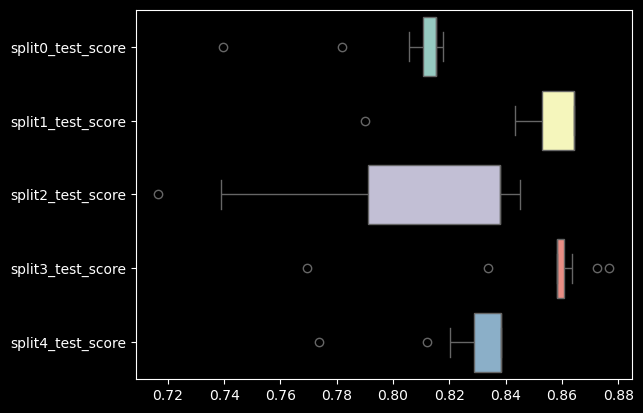

In [46]:
print(f'Número ideal de features é: {rfecv.n_features_}')

print(f'Quais características foram selecionadas.: {rfecv.support_}')
print(f'O ranking das features: {rfecv.ranking_}')

cv_results = pd.DataFrame(rfecv.cv_results_)
sns.boxplot(cv_results[cv_results.columns[2:]], orient='h');

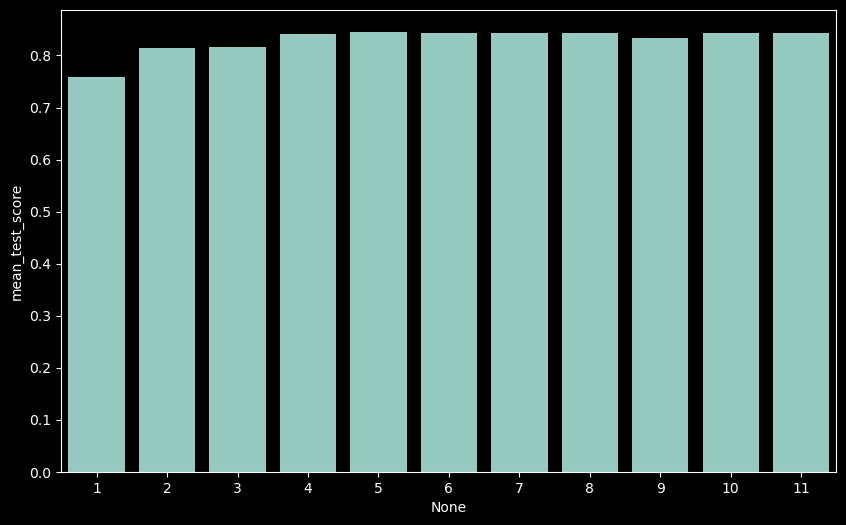

In [42]:
plt.figure(figsize=(10, 6))
sns.barplot(x=cv_results.index + 1, y='mean_test_score', data=cv_results);

Percebe-se também que, gradualmente, conforme vamos removendo as features, o valor do score diminui. Porém, até cerca de 5 ou 7 features, o valor se mantém muito próximo do que temos quando utilizamos 11 features.

Esse dado é extremamente relevante, pois cada uma dessas informações precisou ser coletada. Num cenário em que é preciso coletar ativamente uma informação, pode ser interessante coletar um número menor de dados. Nesse caso, descobrimos que o ideal foi usar 5 informações.

Contudo, se utilizássemos apenas 5 features, a perda não seria tão significativa e poderíamos coletar e armazenar uma quantidade menor de dados.

**********************************************************************
Relatório de Classificação para o Conjunto de Treino :

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       318
           1       0.80      0.73      0.76       216

    accuracy                           0.81       534
   macro avg       0.81      0.80      0.80       534
weighted avg       0.81      0.81      0.81       534

*******************************************************
Matriz de Confusão para o Conjunto de Treino :

[[278  40]
 [ 59 157]]
**********************************************************************


**********************************************************************
Relatório de Classificação para o Conjunto de Teste :

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       106
           1       0.81      0.71      0.76        72

    accuracy                           0.81       178
   macro avg       0.81      0.80      0.80       178
weighted avg       0.81      0.81      0.81       178

*******************************************************
Matriz de Confusão para o Conjunto de Teste :

[[94 12]
 [21 51]]
**********************************************************************


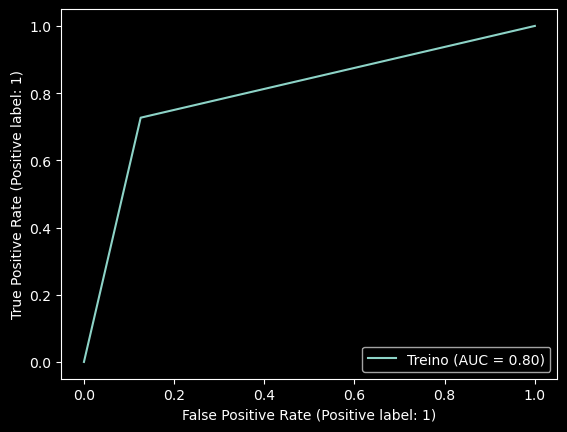

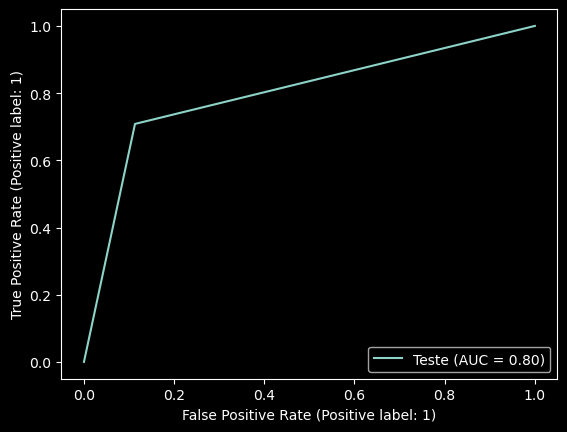

In [25]:
#######################################################################################
# Avaliação no conjunto de treino # Verificando Over/Under(Fitting)
previsoes_treino = rfecv.predict(x_treino)
avaliar_modelo(y_treino, previsoes_treino, "Treino")

# Avaliação no conjunto de teste  # Relatório de classificação
previsoes = rfecv.predict(x_teste)
avaliar_modelo(y_teste, previsoes, "Teste")

##############################
# matriz_confusao = confusion_matrix(y_teste, previsoes)
# visualizacao = ConfusionMatrixDisplay(confusion_matrix= matriz_confusao)
# visualizacao.plot();
#######################################################################################

# FIM